## Optiver Competition 
Team: Brandon, Jatindeep, Alex, Avi

**Overview:** I created a Jupyter notebook from our last notebook where we can develop models here and test the MAE since it takes hours on Kaggle. After we develop some solid models, we can then submit them on kaggle. We will automatically start with the 50 features, as well as the targets. And go from there. Feel free to add visualization as it will help us better understand the models responses to our changes.

I will begin by just adding our feature calculations below

In [5]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm

def get_rsi(df, period):

    delta = df['wap'].pct_change()


    # Calculate the average gain and average loss for the specified period
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(period).mean()
    avg_loss = loss.rolling(period).mean()

    # Calculate the Relative Strength (RS) by dividing the average gain by the average loss
    rs = avg_gain / avg_loss

    # Calculate the Relative Strength Index (RSI)
    rsi = 100 - (100 / (1 + rs))

    return rsi 

def RSI_Signal(rsi):

    if rsi > 70: # Overbought
        return -1
    
    elif rsi < 30: # Oversold
        return 1
    
    else: 
        return 0

def obv_volume(delta, volume):

    if delta > 0 :
        return volume
    elif delta < 0 :
        return -volume


def generate_features(df):
    features = ['seconds_in_bucket', 'imbalance_buy_sell_flag',
               'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
                'imb_s1', 'imb_s2'
               ]
    
    df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    
    prices = ['reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap']
    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                df[f'{a}_{b}_imb'] = df.eval(f'({a}-{b})/({a}+{b})')
                features.append(f'{a}_{b}_imb')    
                    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = df[[a,b,c]].max(axis=1)
                    min_ = df[[a,b,c]].min(axis=1)
                    mid_ = df[[a,b,c]].sum(axis=1)-min_-max_

                    df[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)
                    features.append(f'{a}_{b}_{c}_imb2')
    
    
    train_df_1 = pd.DataFrame()
    
    for name, single_stock_train_df in tqdm(df.groupby('stock_id')):

        single_stock_train_df['rsi'] = get_rsi(single_stock_train_df, period = 14)
        single_stock_train_df['rsi signal'] = single_stock_train_df.apply(lambda x: RSI_Signal(x['rsi']), axis = 1)
        train_df_1 = pd.concat([train_df_1, single_stock_train_df], axis = 0)

    features.append('rsi')
    features.append('rsi signal')
    
    
    train_df_2 = pd.DataFrame()

    for name, single_stock_train_df in tqdm(train_df_1.groupby('stock_id')):

        single_stock_train_df['delta(wap)'] = single_stock_train_df['wap'].pct_change()
        single_stock_train_df['Volume Adjust'] = single_stock_train_df.apply(lambda x: obv_volume(x['delta(wap)'], x['matched_size']), axis = 1)
        single_stock_train_df['OBV'] = single_stock_train_df['Volume Adjust'].rolling(window = 14).sum()

        train_df_2 = pd.concat([train_df_2, single_stock_train_df], axis = 0)
    
    features.append('delta(wap)')
    features.append('Volume Adjust')
    features.append('OBV')
    
    train_df_2['Imbalance'] = train_df_2['imbalance_buy_sell_flag'] * train_df_2['imbalance_size']
    train_df_2['Bid/Ask Spread'] = train_df_2['bid_price'] - train_df_2['ask_price']
    
    features.append('Imbalance')
    features.append('Bid/Ask Spread')
    
    
    default_value = -99999999
    train_df_2.fillna(default_value, inplace=True)
    
    # Replace Inf with NaN
    train_df_2.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Replace NaN with a default value (e.g., 0)
    default_value = -99999998
    train_df_2.fillna(default_value, inplace=True)
    
    return train_df_2[features]



### Quick Check of Data
- Taking a quick second to just check out the features and target

In [17]:
df_ = pd.read_csv('train_features.csv')
df_target = pd.read_csv('train_targets.csv')

In [18]:
#Feature Vars
df_

,seconds_in_bucket,imbalance_buy_sell_flag,imbalance_size,matched_size,bid_size,ask_size,reference_price,far_price,near_price,ask_price,...,wap_bid_price_far_price_imb2,wap_bid_price_near_price_imb2,wap_bid_price_ask_price_imb2,rsi,rsi signal,delta(wap),Volume Adjust,OBV,Imbalance,Bid/Ask Spread
0,0,1,3180602.69,13380276.64,60651.50,8493.03,0.999812,-1.000000e+08,-1.000000e+08,1.000026,...,-1.000188,-1.000188,0.138298,-1.000000e+08,0,-1.000000e+08,-99999999.00,-99999999.00,3180602.69,-0.000214
1,10,1,1299772.70,15261106.63,13996.50,23519.16,1.000026,-1.000000e+08,-1.000000e+08,1.000026,...,-1.000080,-1.000080,1.675000,-1.000000e+08,0,-1.080000e-04,-15261106.63,-99999999.00,1299772.70,-0.000214
2,20,1,1299772.70,15261106.63,4665.50,12131.60,0.999919,-1.000000e+08,-1.000000e+08,0.999919,...,-1.000030,-1.000030,2.566667,-1.000000e+08,0,-5.000540e-05,-15261106.63,-99999999.00,1299772.70,-0.000107
3,30,1,1299772.70,15261106.63,55998.00,46203.30,1.000133,-1.000000e+08,-1.000000e+08,1.000133,...,-1.000059,-1.000059,0.813559,-1.000000e+08,0,2.430384e-04,15261106.63,-99999999.00,1299772.70,-0.000107
4,40,1,1218204.43,15342674.90,14655.95,26610.45,1.000455,-1.000000e+08,-1.000000e+08,1.000455,...,-1.000076,-1.000076,1.815789,-1.000000e+08,0,2.319803e-04,15342674.90,-99999999.00,1218204.43,-0.000214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,500,-1,2661783.46,23969215.23,122246.18,425296.17,1.002764,1.000859e+00,1.001494e+00,1.003082,...,0.037270,0.055906,3.478873,9.183017e+01,-1,8.682938e-04,23969215.23,95291596.10,-2661783.46,-0.000318
5237976,510,-1,2658917.61,23972081.09,677012.04,347268.87,1.002764,1.000859e+00,1.001494e+00,1.003082,...,0.110236,0.165354,0.514286,9.252160e+01,-1,1.386070e-04,23972081.09,95499166.08,-2658917.61,-0.000318
5237977,520,-1,1352558.88,23978379.68,225361.65,194630.52,1.001812,1.000859e+00,1.001494e+00,1.002129,...,0.178384,0.534591,0.864706,5.582183e+01,0,-9.890585e-04,-23978379.68,47756275.29,-1352558.88,-0.000317
5237978,530,-1,1352558.88,23978379.68,285559.05,214513.32,1.001812,1.000859e+00,1.001494e+00,1.002129,...,0.189927,0.569182,0.751381,5.596279e+01,0,1.097824e-05,23978379.68,47970143.86,-1352558.88,-0.000317


In [19]:
#Target

df_target

,target
0,-3.029704
1,-5.519986
2,-8.389950
3,-4.010200
4,-7.349849
...,...
5237975,2.310276
5237976,-8.220077
5237977,1.169443
5237978,-1.540184


## Model Analysis
Preliminary: XGboost, Catboost, and LightGBM models averaged prediction 

Note: I had to really change the train function. I added an early stopping callback for each function, made sure everything improved relative to MAE, added parrallelization to every model, made sure the best model in every case was saved, and made the minimum improvement .0001 (besides catboost it doesnt have a threshold built in). Because that seemed like a reasonable improvement that will jump us up the leaderboard each time.

Updates:
- Added a validation set so there is no data leakage when I want to see the MAE on the test set at the end
- Catboost now uses GPU if thats a problem take it out of constructor
- XGboost took a really long time to run and it didn't improve too much after a small # rounds so i reduced it to 5. If we change the xgboost model, then we could change this
- Changed number of folds to 3 just so this can speed up
- Changed catboost iterations to 1500 cuz i didn't see crazy improvment
- This needs cross validation if someone would like to look at that


In [61]:
import lightgbm as lgb 
import xgboost as xgb 
import catboost as cbt 
import numpy as np 
import joblib 
import os 
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

#Time this whole block
start_time = time.time()
# Define the directory path you want to check/create
model_path = '/models'

# Check if the directory exists
if not os.path.exists(model_path):
    os.makedirs(model_path)
TRAINING = True

# Load or preprocess your data
# Example: Load your data into df_ and df_target

if TRAINING:
    X = df_.values
    Y = df_target['target'].values

    # Remove rows with missing target values
    valid_indices = np.isfinite(Y)
    X = X[valid_indices]
    Y = Y[valid_indices]

    # Split the data into training, validation, and test sets
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

models = []

def train(model_dict, modelname='lgb'):
    if TRAINING:
        X_fold_train, X_fold_valid, Y_fold_train, Y_fold_valid = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

        model = model_dict[modelname]

        if modelname == 'lgb':
            callbacks = [lgb.callback.early_stopping(100, first_metric_only=True, verbose=True, min_delta=.0001)]
            model.fit(X_fold_train, Y_fold_train, 
                      eval_set=[(X_fold_valid, Y_fold_valid)], 
                      callbacks=callbacks,
                      )
            model = model.best_iteration_  # best model for lgb saved here

        if modelname == 'xgb':
            callbacks = xgb.callback.EarlyStopping(rounds=5, metric_name="mae", save_best=True, min_delta=.0001)  # best model for xgb saved here
            model.fit(X_fold_train, Y_fold_train, 
                      eval_set=[(X_fold_valid, Y_fold_valid)], 
                      callbacks=[callbacks],
                      verbose=True
                      )

        if modelname == 'cbt':
            model.fit(X_fold_train, Y_fold_train, 
                      eval_set=[(X_fold_valid, Y_fold_valid)], 
                      verbose=1,
                      early_stopping_rounds=100)
            model = model.best_iteration_  # best model for cbt saved here

        models.append(model)
        joblib.dump(model, f'{model_path}/{modelname}.model')
    else:
        models.append(joblib.load(f'{model_path}/{modelname}.model'))
model_dict = {
    'lgb': lgb.LGBMRegressor(objective='regression_l1', n_estimators=500, n_jobs=-1),
    'xgb': xgb.XGBRegressor(tree_method='hist', objective='reg:absoluteerror', n_estimators=500, n_jobs=-1),
    'cbt': cbt.CatBoostRegressor(objective='MAE', iterations=1500, use_best_model=True, task_type='GPU'),
}

#Train each model (no cross validation)
train(model_dict, 'lgb')
train(model_dict, 'xgb')
train(model_dict, 'cbt')

#Timing stuff
end_time = time.time()
elapsed_time = end_time - start_time
print(f'Time to train {len(models)} Models: {elapsed_time:.2f} seconds')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.263060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13576
[LightGBM] [Info] Number of data points in the train set: 3352250, number of used features: 56
[LightGBM] [Info] Start training from score -0.060201
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[37]	valid_0's l1: 6.41091
Evaluated only: l1


C:\Users\User\PycharmProjects\Kaggle_Competitions\venv\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:6.41128
[1]	validation_0-mae:6.41118
[2]	validation_0-mae:6.41107
[3]	validation_0-mae:6.41106
[4]	validation_0-mae:6.41102
[5]	validation_0-mae:6.41103
[6]	validation_0-mae:6.41102
[7]	validation_0-mae:6.41103


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4074523	test: 6.4114410	best: 6.4114410 (0)	total: 29.5ms	remaining: 44.3s
1:	total: 57.2ms	remaining: 42.9s
2:	total: 87.3ms	remaining: 43.5s
3:	total: 116ms	remaining: 43.3s
4:	total: 148ms	remaining: 44.2s
5:	learn: 6.4074469	test: 6.4114392	best: 6.4114392 (4)	total: 180ms	remaining: 44.8s
6:	total: 212ms	remaining: 45.2s
7:	total: 241ms	remaining: 44.9s
8:	total: 270ms	remaining: 44.8s
9:	total: 298ms	remaining: 44.4s
10:	learn: 6.4074434	test: 6.4114368	best: 6.4114368 (10)	total: 328ms	remaining: 44.4s
11:	total: 356ms	remaining: 44.2s
12:	total: 386ms	remaining: 44.1s
13:	total: 418ms	remaining: 44.4s
14:	total: 451ms	remaining: 44.6s
15:	learn: 6.4074362	test: 6.4114368	best: 6.4114357 (13)	total: 480ms	remaining: 44.5s
16:	total: 509ms	remaining: 44.4s
17:	total: 538ms	remaining: 44.3s
18:	total: 569ms	remaining: 44.4s
19:	total: 602ms	remaining: 44.6s
20:	learn: 6.4074332	test: 6.4114363	best: 6.4114357 (13)	total: 634ms	remaining: 44.7s
21:	total: 666ms	remainin

- Calculate predictions for each individual model and plot the predictions vs averages. Then average the predictions and plot. The idea here is to see if one model heavily outweighs the other, or if the averaged prediction works best

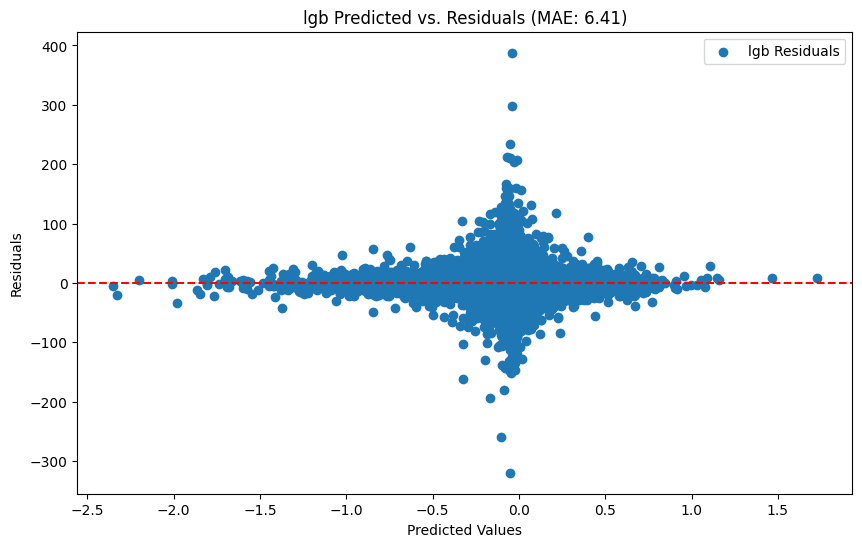

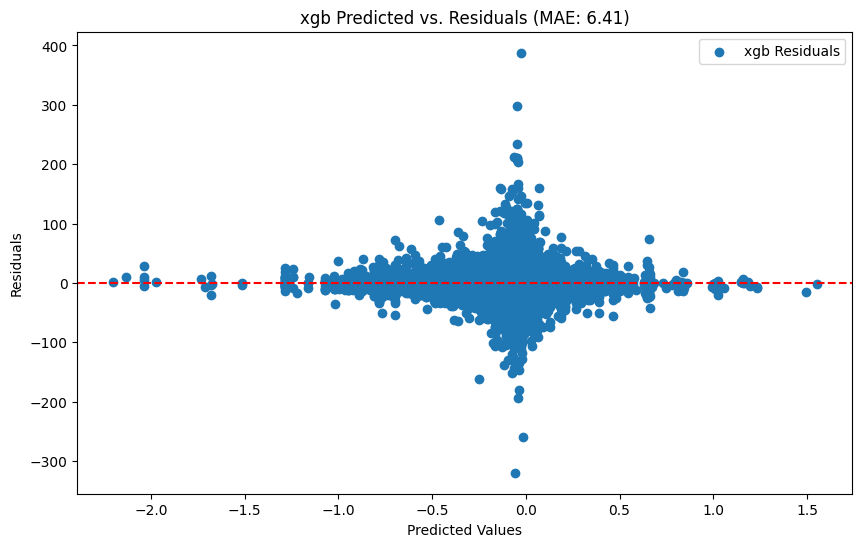

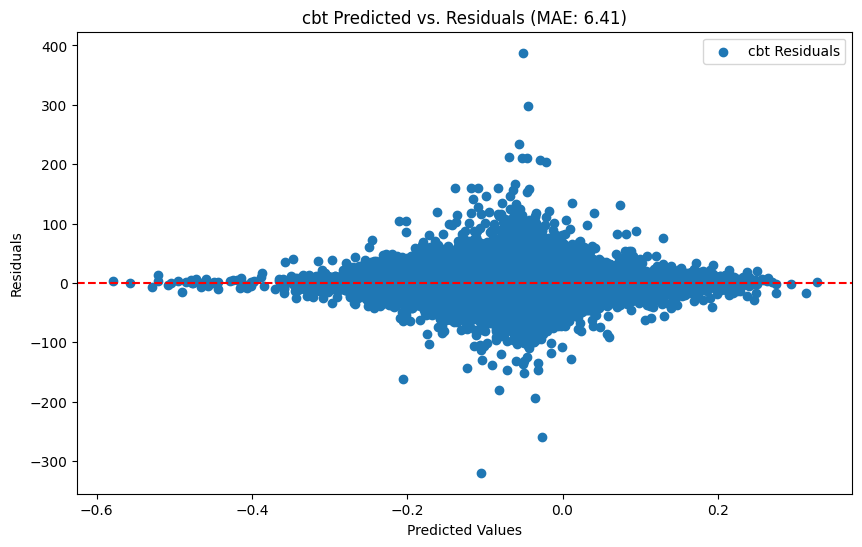

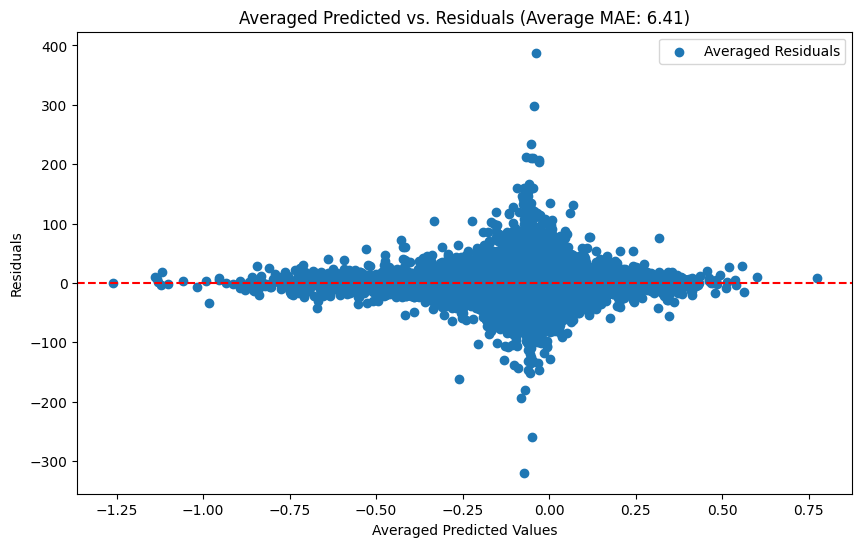

In [71]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Calculate the individual predictions for each model
individual_predictions = {}

for model_name in model_dict:
    model = model_dict[model_name]

    if model_name == 'lgb':
        y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
    else:
        y_pred = model.predict(X_test)

    individual_predictions[model_name] = (Y_test, y_pred)

# Calculate the residuals (differences between true values and predictions) for each model
residuals = {}
mae_values = {}
for model_name, (Y_true, Y_pred) in individual_predictions.items():
    residuals[model_name] = Y_true - Y_pred
    mae = mean_absolute_error(Y_true, Y_pred)
    mae_values[model_name] = mae

# Calculate the residuals for the averaged predictions
avg_predictions = np.mean([individual_predictions[model_name][1] for model_name in model_dict], axis=0)
residuals['average'] = Y_test - avg_predictions
mae_values['average'] = mean_absolute_error(Y_test, avg_predictions)

# Create scatterplots of predicted values versus residuals with MAE values
for model_name in residuals:
    if model_name in individual_predictions:
        plt.figure(figsize=(10, 6))
        plt.scatter(individual_predictions[model_name][1], residuals[model_name], label=f'{model_name} Residuals')
        plt.axhline(0, color='red', linestyle='--')
        plt.xlabel('Predicted Values')
        plt.ylabel('Residuals')
        plt.legend()
        plt.title(f'{model_name} Predicted vs. Residuals (MAE: {mae_values[model_name]:.2f})')
        plt.show()

# Create a scatterplot for the averaged predictions
plt.figure(figsize=(10, 6))
plt.scatter(avg_predictions, residuals['average'], label='Averaged Residuals')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Averaged Predicted Values')
plt.ylabel('Residuals')
plt.legend()
plt.title(f'Averaged Predicted vs. Residuals (Average MAE: {mae_values["average"]:.2f})')
plt.show()

## Principal Component Analysis
**PROBLEM: ALL CURRENT FEATURE VARS SCALED IN MULTIPLE DIFFERENT WAYS THUS PCA MIGHT NOT WORK**
- My idea is to transform the dataset of 50 feature vars and then feed it into whatever ensembling method we decide to use (right now it will be the one of the 3 models and averaged prediction)
- I will begin by plotting the cumulative explained variance

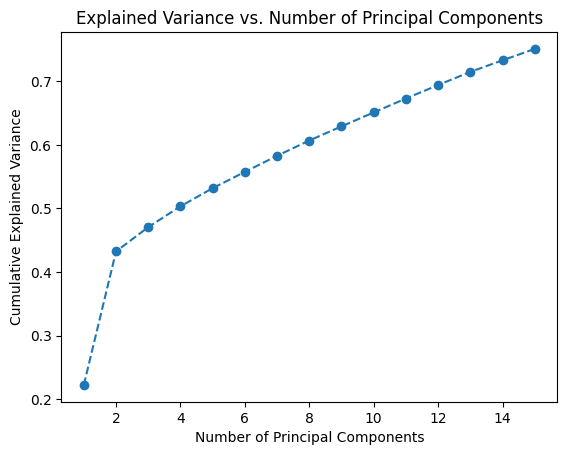

In [80]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Apply PCA to (already scaled) features with the desired number of components
n_components = 15  # Choose the number of components
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(df_) 

#Calculate explained and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot the explained variance
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

It seems like 5 is a pretty reasonable number of PCs to use so I will continue with this to see if it improves our model

In [78]:
# Choose the 5 components and transform the old feature vars
n_components_selected = 5
pca_selected = PCA(n_components=n_components_selected)
X_pca_selected = pca_selected.fit_transform(df_) #This is what we will use as the new X (feature) data

#Need to split the data again since it is transformed (just the x values but just including y for simplicity)
if TRAINING:
    X = X_pca_selected
    Y = df_target['target'].values

    # Remove rows with missing target values
    valid_indices = np.isfinite(Y)
    X = X[valid_indices]
    Y = Y[valid_indices]

    # Split the data into training, validation, and test sets
    X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.2, random_state=42)
    X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

models = []

#Train each model (no cross validation)
train(model_dict, 'lgb')
train(model_dict, 'xgb')
train(model_dict, 'cbt')


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007295 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3352250, number of used features: 5
[LightGBM] [Info] Start training from score -0.060201
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1]	valid_0's l1: 6.41145
Evaluated only: l1


C:\Users\User\PycharmProjects\Kaggle_Competitions\venv\lib\site-packages\xgboost\sklearn.py:885: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mae:6.41150
[1]	validation_0-mae:6.41155
[2]	validation_0-mae:6.41158
[3]	validation_0-mae:6.41162
[4]	validation_0-mae:6.41166
[5]	validation_0-mae:6.41166


Default metric period is 5 because MAE is/are not implemented for GPU


0:	learn: 6.4074535	test: 6.4114428	best: 6.4114428 (0)	total: 37.1ms	remaining: 55.7s
1:	total: 60.5ms	remaining: 45.3s
2:	total: 82.9ms	remaining: 41.4s
3:	total: 105ms	remaining: 39.5s
4:	total: 127ms	remaining: 38s
5:	learn: 6.4074535	test: 6.4114446	best: 6.4114428 (0)	total: 151ms	remaining: 37.7s
6:	total: 175ms	remaining: 37.4s
7:	total: 199ms	remaining: 37.1s
8:	total: 223ms	remaining: 36.9s
9:	total: 246ms	remaining: 36.7s
10:	learn: 6.4074523	test: 6.4114446	best: 6.4114428 (0)	total: 270ms	remaining: 36.5s
11:	total: 293ms	remaining: 36.3s
12:	total: 315ms	remaining: 36s
13:	total: 337ms	remaining: 35.7s
14:	total: 359ms	remaining: 35.6s
15:	learn: 6.4074511	test: 6.4114464	best: 6.4114428 (0)	total: 382ms	remaining: 35.4s
16:	total: 407ms	remaining: 35.5s
17:	total: 430ms	remaining: 35.4s
18:	total: 454ms	remaining: 35.4s
19:	total: 477ms	remaining: 35.3s
20:	learn: 6.4074499	test: 6.4114470	best: 6.4114428 (0)	total: 508ms	remaining: 35.8s
21:	total: 532ms	remaining: 35.7